In [44]:
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np
import cv2 as cv
from os import listdir, makedirs
from os.path import isfile, join, splitext
from scipy import ndimage
import sys

In [45]:
# jupyter specific func
def disp(img, thresh):
    if len(thresh.shape) == 3 and thresh.shape[2] == 3:
        thresh_3ch = thresh
    else:
        thresh_3ch = cv.cvtColor(thresh, cv.COLOR_GRAY2BGR)
    numpy_horizontal_concat = np.concatenate((img, thresh_3ch), axis=1)
    cv.imshow('Numpy Horizontal Concat', numpy_horizontal_concat)
    cv.waitKey(0)
    cv.destroyAllWindows()

In [46]:
def bbox(mask, img):
    m = np.any(mask != [0, 0, 0], axis=2)
    coords = np.argwhere(m)
    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0) + 1
    boundary_flag = False
    if x0 == 0 or x1 == img.shape[0] or y0 == 0 or y1 == img.shape[1]:
        boundary_flag = True
    cropped = img[x0:x1, y0:y1]
    return cropped, boundary_flag

In [47]:
def crop_img(img, CANNY_THRESH_1=7, CANNY_THRESH_2=28):
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    edges = cv.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2)
    edges = cv.dilate(edges, None)
    edges = cv.erode(edges, None)
    cropped, boundary_flag = bbox(cv.cvtColor(edges, cv.COLOR_GRAY2BGR), img)
    return cropped, boundary_flag

In [48]:
def crop_img_bartek(img):
    BLUR = 5
    CANNY_THRESH_1 = 7
    CANNY_THRESH_2 = 28
    MASK_DILATE_ITER = 9
    MASK_ERODE_ITER = 9
    MASK_COLOR = (0.0,0.0,1.0) # In BGR format

    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)

    edges = cv.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2)
    edges = cv.dilate(edges, None)
    edges = cv.erode(edges, None)

    contour_info = []
    im, contours, _ = cv.findContours(edges, cv.RETR_LIST, cv.CHAIN_APPROX_NONE)

    for c in contours:
        contour_info.append((
            c,
            cv.isContourConvex(c),
            cv.contourArea(c),
        ))
    contour_info = sorted(contour_info, key=lambda c: c[2], reverse=True)
    max_contour = contour_info[0]

    # Mask is black, polygon is white
    mask = np.zeros(edges.shape)
    cv.fillConvexPoly(mask, max_contour[0], (255))

    mask = cv.dilate(mask, None, iterations=MASK_DILATE_ITER)
    mask = cv.erode(mask, None, iterations=MASK_ERODE_ITER)
    mask = cv.GaussianBlur(mask, (BLUR, BLUR), 0)
    mask_stack = np.dstack([mask]*3)    # Create 3-channel alpha mask
    cropped = bbox(mask_stack, img)
    return cropped

In [60]:
def scale_img(img, target_dim=224):
    scale = target_dim / max(img.shape[0],img.shape[1])
    scaled = cv.resize(img,None,fx=scale, fy=scale, interpolation = cv.INTER_CUBIC)

    target = np.zeros((target_dim, target_dim, 3), np.uint8)
    target[:] = 255 # white

    x0, y0 = scaled.shape[:2]
    x1, y1 = target.shape[:2]
    xoff = round((x1-x0)/2)
    yoff = round((y1-y0)/2)
    target[xoff:xoff+x0, yoff:yoff+y0] = scaled
    return target

In [61]:
def process_img(img, rotation_angle, CANNY_THRESH_1=7, CANNY_THRESH_2=28):
    rotated = ndimage.rotate(img, rotation_angle, mode='nearest')
    cropped, _ = crop_img(rotated, CANNY_THRESH_1, CANNY_THRESH_2)
    scaled = scale_img(cropped)
    return scaled

In [62]:
def progress_bar(progress):
    sys.stdout.write('\r                                                                       ')
    sys.stdout.flush()
    sys.stdout.write('\r')
    sys.stdout.write('[')
    for i in range(1,10):
        if progress >= i*10:
            sys.stdout.write("=")
        else:
            sys.stdout.write(" ")
    sys.stdout.write(f'] {progress}%')            
    sys.stdout.flush()

In [63]:
def dir_recursive(path, out_path):
    dirs = [f for f in listdir(path) if not isfile(join(path, f))]
    files = [f for f in listdir(path) if isfile(join(path, f))]
    if len(files) != 0:
        process_dir(path, out_path)
    for d in dirs:
        dir_recursive(join(path,d), join(out_path,d))

In [66]:
def process_dir(path, out_path, angle_increment=18):
    images = [(cv.imread(join(path,f)), f) for f in listdir(path) if isfile(join(path, f)) and (splitext(f)[1] == '.jpg' or splitext(f)[1] == '.png')]
    try:
        makedirs(out_path)
    except OSError:
        pass
   # canny_x, canny_y = 1,220
    for img, img_name in images:
        rotation_angle = 0
        print(f'processing: {join(path,img_name)}')
        _, boundary_flag = crop_img(img)
        if boundary_flag:
            print('Lego brick is out of bounds!')
        while(not boundary_flag and rotation_angle < 360):
            if angle_increment != 360:
                progress_bar(rotation_angle*100//(360-angle_increment))
            name, ext = splitext(img_name)
            target_filename = name + '_' + str(rotation_angle) + ext
            out = process_img(img, rotation_angle)
            cv.imwrite(join(out_path,target_filename), out)
            rotation_angle += angle_increment
        print(f' {360//angle_increment} images generated')

In [67]:
path = 'train/'
out_path = 'train2/'
dir_recursive(path,out_path)

processing: train/3031/3031_Spring Yellowish Green_2_1589354898.png
[=========] 100%                                                        20 images generated
processing: train/3031/3031_Medium Blue_4_1588905030.png
[=========] 100%                                                        20 images generated
processing: train/3031/3031_Spring Yellowish Green_7_1587711434.png
Lego brick is out of bounds!
 20 images generated
processing: train/3031/3031_Spring Yellowish Green_8_1587711442.png
Lego brick is out of bounds!
 20 images generated
processing: train/3031/3031_Earth Green_2_1589236199.png
[=========] 100%                                                        20 images generated
processing: train/3031/3031_Light Nougat_8_1587523155.png
[=========] 100%                                                        20 images generated
processing: train/3031/3031_Medium Azur_9_1588594706.png
Lego brick is out of bounds!
 20 images generated
processing: train/3031/3031_Black_5_1589097339.pn

In [21]:
import time, sys
for i in range(101):
    progressbar(i)
    time.sleep(0.1)

NameError: name 'progressbar' is not defined

In [28]:
def bbox2(mask, img):
    m = np.any(mask != [0, 0, 0], axis=2)
    coords = np.argwhere(m)
    x0, y0 = coords.min(axis=0)
    x1, y1 = coords.max(axis=0) + 1
    boundary_flag = False
    if x0 == 0 or x1 == img.shape[0] or y0 == 0 or y1 == img.shape[1]:
        boundary_flag = True
    print(x0,x1,y0,y1)
    cropped = img[x0:x1, y0:y1]
    return cropped, boundary_flag

In [22]:
def crop_img2(img):
    CANNY_THRESH_1 = 7
    CANNY_THRESH_2 = 28
    gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    edges = cv.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2)
    edges = cv.dilate(edges, None)
    edges = cv.erode(edges, None)
    cropped, boundary_flag = bbox2(cv.cvtColor(edges, cv.COLOR_GRAY2BGR), img)
    return cropped, boundary_flag


329 400 11 86
True


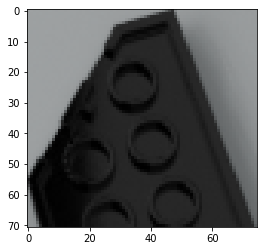

In [30]:

img = cv.imread('/home/konrad/Documents/legotrain/train/2419/2419_Black_9_1589080548.png')

CANNY_THRESH_1 = 1
CANNY_THRESH_2 = 255
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
edges = cv.Canny(gray, CANNY_THRESH_1, CANNY_THRESH_2)
edges = cv.dilate(edges, None)
edges = cv.erode(edges, None)
cropped, bf = bbox2(cv.cvtColor(edges, cv.COLOR_GRAY2BGR), img)
plt.imshow(cropped)
print(bf)
#scaled = scale_img(cropped)
#plt.imshow(img)


In [ ]:
plt.imshow(scaled)